This notebook contains the applications of Binary Classification using Transfer learning and Ensemble Learning with weighted voting. In the first part, all models are trained seperatedly. In the seconds part using test sets predictions were made and ensemble model is created. 

# Binary Classification using Transfer Learning

## Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import sklearn
import glob 
import torch
import pickle
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import WeightedRandomSampler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   
torch.cuda.empty_cache()

In [ ]:
cd drive/MyDrive/Ars_machinae_autodiscentis/Inceptum/Deep_Learning

/content/drive/.shortcut-targets-by-id/17nJclndF8GuAZRXKNYnj1vT31d1lGUTN/Inceptum/Deep_Learning


## Resnet18

In [ ]:
'''
This part of the code is modified based on need of running each magnification or magnification independent approach. 
If magnification independent will be run -> data_dir should be in data_all, otherwise data_dir should be the magnification folder 40x,100x,200x or 400x.
'''
# mag = '400x'
# data_dir = f'{mag}}/'

data_dir = f'data_all/' # Magnification independent approach.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=40,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Checking the class weights.
train_y = image_datasets['train'].targets
val_y = image_datasets['val'].targets
print("Train set label distribution", Counter(train_y))
print("Val set label distribution", Counter(val_y))
class_weights_train = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_y), y = train_y)                                                    
class_weights_train = torch.tensor(class_weights_train ,dtype=torch.float).cuda()
print(class_weights_train)
class_weights_val = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(val_y), y = val_y)                                                    
class_weights_val = torch.tensor(class_weights_val ,dtype=torch.float).cuda()
print(class_weights_val)

Train set label distribution Counter({1: 2829, 0: 1077})
Val set label distribution Counter({1: 704, 0: 394})
tensor([1.8134, 0.6903], device='cuda:0')
tensor([1.3934, 0.7798], device='cuda:0')


In [ ]:
# Accuracy and loss plots to be drawn in the training loop. 

'''
def draw_plot_loss(loss_train, loss_val, mag=mag):
# Draws training and validation loss curves in magnification dependent model.
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(loss_val,label="val")
    plt.plot(loss_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'lossGraphs/model_resnet/{mag}/{mag}_losses.png')
    plt.show()

def draw_plot_acc(acc_train, acc_val, mag=mag):
# Draws training and validation accuracy curves in magnification dependent model. 

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(acc_val,label="val")
    plt.plot(acc_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'lossGraphs/model_resnet/{mag}/{mag}_acc.png')
    plt.show()
''' 

def draw_plot_loss_for_all(loss_train, loss_val): 
# Draws training and validation loss curves in magnification independent model. 

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(loss_val,label="val")
    plt.plot(loss_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'lossGraphs/model_resnet/data_all/all_losses.png')
    plt.show()

def draw_plot_acc_for_all(acc_train, acc_val):
# Draws training and validation accuracy curves in magnification independent model. 
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(acc_val,label="val")
    plt.plot(acc_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'lossGraphs/model_resnet/data_all/all_acc.png')
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
  
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    val_losses = []
    train_losses = []
    train_acc=[]
    val_acc=[]

    last_loss = 100
    patience = 3
    triggertimes = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            if phase == 'val':
              val_losses.append(epoch_loss)
              val_acc.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if epoch_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                print('Best val Acc: {:4f}'.format(best_acc))

                #draw_plot_loss(train_losses, val_losses)
                #draw_plot_acc(train_acc, val_acc)
                draw_plot_loss_for_all(train_losses, val_losses)
                draw_plot_acc_for_all(train_acc, val_acc)

                # load best model weights
                model.load_state_dict(best_model_wts)
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = epoch_loss
                    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    draw_plot_loss(train_losses, val_losses)
    draw_plot_acc(train_acc, val_acc)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_resnet = models.resnet18(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2) #single layer feed forward network

model_dense = model_resnet.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_train))

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_resnet.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4713 Acc: 0.7819
val Loss: 0.4230 Acc: 0.8525
trigger times: 0
Epoch 2/20
----------
train Loss: 0.2427 Acc: 0.9117
val Loss: 0.3882 Acc: 0.8561
trigger times: 0
Epoch 3/20
----------
train Loss: 0.1851 Acc: 0.9296
val Loss: 0.3361 Acc: 0.8443
trigger times: 0
Epoch 4/20
----------
train Loss: 0.1570 Acc: 0.9391
val Loss: 0.3490 Acc: 0.8461
Trigger Times: 1
Epoch 5/20
----------
train Loss: 0.1333 Acc: 0.9488
val Loss: 0.3441 Acc: 0.8506
trigger times: 0
Epoch 6/20
----------
train Loss: 0.1181 Acc: 0.9557
val Loss: 0.4058 Acc: 0.8515
Trigger Times: 1
Epoch 7/20
----------
train Loss: 0.1142 Acc: 0.9593
val Loss: 0.3766 Acc: 0.8525
trigger times: 0
Epoch 8/20
----------
train Loss: 0.1172 Acc: 0.9560
val Loss: 0.3112 Acc: 0.8707
trigger times: 0
Epoch 9/20
----------
train Loss: 0.1091 Acc: 0.9631
val Loss: 0.3482 Acc: 0.8588
Trigger Times: 1
Epoch 10/20
----------
train Loss: 0.1045 Acc: 0.9590
val Loss: 0.3565 Acc: 0.8561
Trigger Times: 2
Epoch 11/20
----------
train Lo

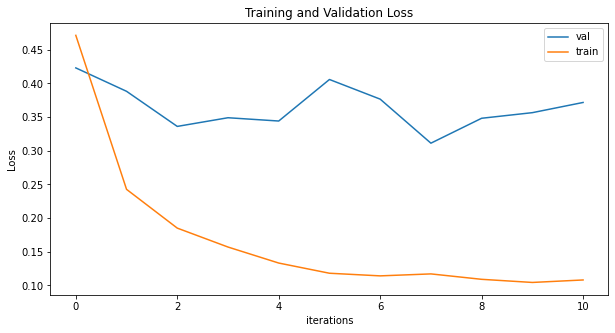

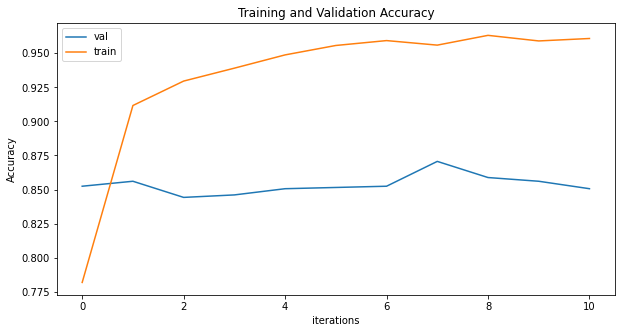

In [ ]:
model_res = train_model(model_resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

In [ ]:
#torch.save(model_res.state_dict(), f"saved_model_pytorch/model_resnet_{mag}_statedict.pt")
#torch.save(model_res, f"saved_model_pytorch/model_resnet_{mag}_scomplete.pt")

torch.save(model_res.state_dict(), f"saved_model_pytorch/model_resnet_all_statedict.pt")
torch.save(model_res, f"saved_model_pytorch/model_resnet_all_scomplete.pt")

## Densenet

In [ ]:
'''
This part of the code is modified based on need of running each magnification or magnification independent approach. 
If magnification independent will be run -> data_dir should be in data_all, otherwise data_dir should be the magnification folder 40x,100x,200x or 400x.
'''
# mag = '400x'
# data_dir = f'{mag}}/'
data_dir = f'data_all/' # Magnification independent approach.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=40,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_y = image_datasets['train'].targets
val_y = image_datasets['val'].targets
print("Train set label distribution", Counter(train_y))
print("Val set label distribution", Counter(val_y))
class_weights_train = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_y), y = train_y)                                                    
class_weights_train = torch.tensor(class_weights_train ,dtype=torch.float).cuda()
print(class_weights_train)

In [ ]:
''' Plots for magnification dependent models. 
def draw_plot_loss(loss_train, loss_val, mag=mag):
# Draws training and validation loss curves in magnification dependent model. 
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(loss_val,label="val")
    plt.plot(loss_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'lossGraphs/model_dense/{mag}/{mag}_losses.png')
    plt.show()

def draw_plot_acc(acc_train, acc_val, mag=mag):
# Draws training and validation accuracy curves in magnification dependent model. 
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(acc_val,label="val")
    plt.plot(acc_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'lossGraphs/model_dense/{mag}/{mag}_acc.png')
    plt.show()
'''

def draw_plot_loss_for_all(loss_train, loss_val): 
# Draws training and validation loss curves in magnification independent model. 
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(loss_val,label="val")
    plt.plot(loss_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'lossGraphs/model_dense/data_all/all_losses.png')
    plt.show()

def draw_plot_acc_for_all(acc_train, acc_val):
# Draws training and validation accuracy curves in magnification independent model. 
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(acc_val,label="val")
    plt.plot(acc_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'lossGraphs/model_dense/data_all/all_acc.png')
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    val_losses = []
    train_losses = []
    train_acc=[]
    val_acc=[]

    last_loss = 100
    patience = 3
    triggertimes = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            if phase == 'val':
              val_losses.append(epoch_loss)
              val_acc.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if epoch_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                print('Best val Acc: {:4f}'.format(best_acc))

                #draw_plot_loss(train_losses, val_losses)
                #draw_plot_acc(train_acc, val_acc)
                draw_plot_loss_for_all(train_losses, val_losses)
                draw_plot_acc_for_all(train_acc, val_acc)

                # load best model weights
                model.load_state_dict(best_model_wts)
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = epoch_loss
                    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    draw_plot_loss(train_losses, val_losses)
    draw_plot_acc(train_acc, val_acc)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_dense = models.densenet161(pretrained=True)
num_ftrs = model_dense.classifier.in_features
model_dense.classifier = nn.Linear(num_ftrs, 2) #single layer feed forward network
model_dense = model_dense.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_train))

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_dense.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_dense = train_model(model_dense, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

In [ ]:
#torch.save(model_dense.state_dict(), f"saved_model_pytorch/model_dense_{mag}_statedict.pt")
#torch.save(model_dense, f"saved_model_pytorch/model_dense_{mag}_scomplete.pt")

torch.save(model_dense.state_dict(), f"saved_model_pytorch/model_densenet_all_statedict.pt")
torch.save(model_dense, f"saved_model_pytorch/model_densenet_all_scomplete.pt")

In [ ]:
summary(model_dense,input_size=(3,256,256))


## VGG16

In [ ]:
'''
This part of the code is modified based on need of running each magnification or magnification independent approach. 
If magnification independent will be run -> data_dir should be in data_all, otherwise data_dir should be the magnification folder 40x,100x,200x or 400x.
'''
# mag = '400x'
# data_dir = f'{mag}}/'
data_dir = f'data_all/' # Magnification independent approach.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=40,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_y = image_datasets['train'].targets
val_y = image_datasets['val'].targets
print("Train set label distribution", Counter(train_y))
print("Val set label distribution", Counter(val_y))
class_weights_train = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_y), y = train_y)                                                    
class_weights_train = torch.tensor(class_weights_train ,dtype=torch.float).cuda()
print(class_weights_train)
class_weights_val = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(val_y), y = val_y)                                                    
class_weights_val = torch.tensor(class_weights_val ,dtype=torch.float).cuda()
print(class_weights_val)

In [ ]:
''' Plots for magnification dependent model. 
def draw_plot_loss(loss_train, loss_val, mag=mag):
# Draws training and validation loss curves in magnification dependent model. 
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(loss_val,label="val")
    plt.plot(loss_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'lossGraphs/model_vgg/{mag}/{mag}_losses.png')
    plt.show()

def draw_plot_acc(acc_train, acc_val, mag=mag):
# Draws training and validation accuracy curves in magnification dependent model. 
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(acc_val,label="val")
    plt.plot(acc_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'lossGraphs/model_vgg/{mag}/{mag}_acc.png')
    plt.show()
'''

def draw_plot_loss_for_all(loss_train, loss_val): 
# Draws training and validation loss curves in magnification independent model. 
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(loss_val,label="val")
    plt.plot(loss_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'lossGraphs/model_vgg/data_all/all_losses.png')
    plt.show()

def draw_plot_acc_for_all(acc_train, acc_val):
# Draws training and validation accuracy curves in magnification independent model.
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(acc_val,label="val")
    plt.plot(acc_train,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'lossGraphs/model_vgg/data_all/all_acc.png')
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    val_losses = []
    train_losses = []
    train_acc=[]
    val_acc=[]

    last_loss = 100
    patience = 5
    triggertimes = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            if phase == 'val':
              val_losses.append(epoch_loss)
              val_acc.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if epoch_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                print('Best val Acc: {:4f}'.format(best_acc))

                #draw_plot_loss(train_losses, val_losses)
                #draw_plot_acc(train_acc, val_acc)
                draw_plot_loss_for_all(train_losses, val_losses)
                draw_plot_acc_for_all(train_acc, val_acc)

                # load best model weights
                model.load_state_dict(best_model_wts)
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = epoch_loss
                    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #draw_plot_loss(train_losses, val_losses)
    #draw_plot_acc(train_acc, val_acc)
    draw_plot_loss_for_all(train_losses, val_losses)
    draw_plot_acc_for_all(train_acc, val_acc)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_vgg = models.vgg16(pretrained=True)
num_ftrs = model_vgg.classifier[6].in_features #in_feature is the number of inputs for your linear layer
model_vgg.classifier[6] = nn.Linear(num_ftrs, 2) #single layer feed forward network. Applies a linear transformation to the incoming data

model_eff = model_vgg.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_train))

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_vgg.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4213 Acc: 0.8113
val Loss: 0.4021 Acc: 0.7332
trigger times: 0
Epoch 2/20
----------
train Loss: 0.2616 Acc: 0.8912
val Loss: 0.5329 Acc: 0.7596
Trigger Times: 1
Epoch 3/20
----------
train Loss: 0.2122 Acc: 0.9227
val Loss: 0.3624 Acc: 0.8515
trigger times: 0
Epoch 4/20
----------
train Loss: 0.1563 Acc: 0.9391
val Loss: 0.5205 Acc: 0.7905
Trigger Times: 1
Epoch 5/20
----------
train Loss: 0.1530 Acc: 0.9409
val Loss: 0.3826 Acc: 0.8242
trigger times: 0
Epoch 6/20
----------
train Loss: 0.1402 Acc: 0.9467
val Loss: 0.3970 Acc: 0.8352
Trigger Times: 1
Epoch 7/20
----------
train Loss: 0.0913 Acc: 0.9672
val Loss: 0.4525 Acc: 0.8488
Trigger Times: 2
Epoch 8/20
----------
train Loss: 0.0811 Acc: 0.9703
val Loss: 0.4897 Acc: 0.8579
Trigger Times: 3
Epoch 9/20
----------
train Loss: 0.0730 Acc: 0.9721
val Loss: 0.5344 Acc: 0.8297
Trigger Times: 4
Epoch 10/20
----------
train Loss: 0.0702 Acc: 0.9731
val Loss: 0.5187 Acc: 0.8443
trigger times: 0
Epoch 11/20
----------
train Lo

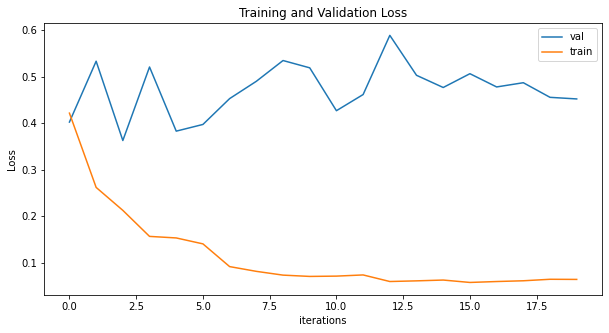

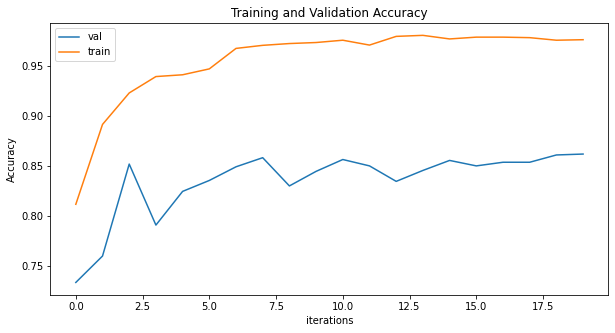

In [ ]:
model_vgg = train_model(model_vgg, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

In [ ]:
#torch.save(model_vgg.state_dict(), f"saved_model_pytorch/model_vgg_{mag}_statedict.pt")
#torch.save(model_vgg, f"saved_model_pytorch/model_vgg_{mag}_scomplete.pt")

torch.save(model_vgg.state_dict(), f"saved_model_pytorch/model_vgg_all_statedict.pt")
torch.save(model_vgg, f"saved_model_pytorch/model_vgg_all_scomplete.pt")

## Binary Classifier

To perfom the binary classification on the test dataset, we first get the paths of test set. Then, each image is read with necessary transformations and prediction is made from previously saved models. 

In [ ]:
# Functions 
def give_paths(mag):    

  paths_test_b = [];
  paths_test_m = [];

  path_test_b=f'data/{mag}x/test/benign'
  path_test_m=f'data/{mag}x/test/malignant'

  test_b =glob.glob(path_test_b+ '/*.png')
  test_m =glob.glob(path_test_m+ '/*.png')

  paths_test_b.append(test_b);
  paths_test_m.append(test_m);

  return paths_test_b, paths_test_m

def give_paths_data_all():
   # in terms of magnification independent approach (where data_all is used. )
  paths_test_b = [];
  paths_test_m = [];

  path_test_b=f'data_all/test/benign'
  path_test_m=f'data_all/test/malignant'

  test_b =glob.glob(path_test_b+ '/*.png')
  test_m =glob.glob(path_test_m+ '/*.png')

  paths_test_b.append(test_b);
  paths_test_m.append(test_m);

  return paths_test_b, paths_test_m

def all_paths_data_all():
  # in terms of magnification independent approach (where data_all is used. )
  paths=[];
  paths.append(give_paths_data_all())
  return paths

def all_paths():
  paths=[];
  magnifications=['40','100','200','400']
  for mag in magnifications:
    paths.append(give_paths(mag))
  return paths

# Image transformationf for the test set. 
transform_image = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_image = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predictions_test_dl(paths, model):
  # contains prediction for the val set in the deep learning files. 
  prediction_list=[]
  img_pred=[]
  patient_id=[]
  pat_all=[]
  for path in tqdm(paths):
    id = path.rsplit('/', 1)[1].split("-")[2]
    patient_id.append(id)
    img = Image.open(path)
    t_img = transform_image(img)
    with torch.no_grad():
      t_img = t_img.unsqueeze(0)
      prediction = (model(t_img)).tolist()
      img_pred.append(prediction)
  prediction_list.append(img_pred)
  pat_all.append(patient_id)
  return prediction_list, pat_all

def get_prediction(test_ben_data, test_mal_data, model):

  list_ben, patient_ben = predictions_test_dl(test_ben_data[0], model)
  list_mal, patient_mal = predictions_test_dl(test_mal_data[0], model)

  return list_ben, list_mal, patient_ben, patient_mal

def get_prediction_data_all(test_ben_data, test_mal_data, model):

  list_ben, patient_ben = predictions_test_dl(test_ben_data, model)
  list_mal, patient_mal = predictions_test_dl(test_mal_data, model)

  return list_ben, list_mal, patient_ben, patient_mal


def patient_score(pat_list, test_ytrue, test_ypred):
  '''
  Creates dataframe and calculate recognition rate for each binary model.
  '''
  df = pd.DataFrame()
  df['patient_id'] = pat_list
  df['y_test'] = test_ytrue
  df['y_pred'] = test_ypred
  df['comparison'] = np.where(df['y_test'] == df['y_pred'], 1, 0)

  num_img_p=[]
  true_counts_p=[]
  for d in df.groupby('patient_id'): # Groupby the patients based on their Id's
    true_counts=d[1].comparison.sum() # The total correctly classfied images. The sum of comparison column. 
    true_counts_p.append(true_counts) # Creating Nrec value. 
    values=d[1].patient_id.value_counts(dropna=False) # Count number of apperances of patient Id per patient = # number of images obtained per patient.
    num_img_p.append(values[0]) # Creating Np value.

    p_score_arr=[]
    for i in range(len(num_img_p)): # Both arrays are in the same lenght 
      p_score=true_counts_p[i]/num_img_p[i] # For each index, calculate p score.
      p_score_arr.append(p_score) 

  return p_score_arr


def recognition_rate(p_score_arr):
  '''
  p_score_arr: p scores. - Array.
  It returns recognition rate.
  '''
  sum_p_score=np.array(p_score_arr).sum() # Sum of p score.
  rec_rate=sum_p_score/len(p_score_arr) # Calculation of the recognition rate. 
  return rec_rate

def save_files(data_ben, data_mal, model, mag, m ):
  list_ben, list_mal, patient_ben, patient_mal = tqdm(get_prediction(data_ben, data_mal, model))
  patient_list = patient_ben[0]+patient_mal[0]
  ## Save the Model predictions into pickle files for reusability.
  with open(f'saved_predictions/ben_{mag}x_{m}.pickle', 'wb') as handle:
      pickle.dump(list_ben, handle)
  with open(f'saved_predictions/mal_{mag}x_{m}.pickle', 'wb') as handle:
      pickle.dump(list_mal, handle)
  with open(f'saved_predictions/patients_{mag}x_{m}.pickle', 'wb') as handle:
      pickle.dump(patient_list, handle)

def save_files_data_all(data_ben, data_mal, model, m ):
  list_ben, list_mal, patient_ben, patient_mal = tqdm(get_prediction_data_all(data_ben, data_mal, model))
  patient_list = patient_ben[0]+patient_mal[0]
  ## Save the Model predictions into pickle files for reusability.
  with open(f'saved_predictions/ben_all_{m}.pickle', 'wb') as handle:
      pickle.dump(list_ben, handle)
  with open(f'saved_predictions/mal_all_{m}.pickle', 'wb') as handle:
      pickle.dump(list_mal, handle)
  with open(f'saved_predictions/patients_all_{m}.pickle', 'wb') as handle:
      pickle.dump(patient_list, handle)

# Read presaved pickle files to save time. 
def read_files(mag, m ):
  ben = pickle.load(open(f'saved_predictions/ben_{mag}x_{m}.pickle','rb'))
  mal = pickle.load(open(f'saved_predictions/mal_{mag}x_{m}.pickle','rb'))
  pat_list = pickle.load(open(f'saved_predictions/patients_{mag}x_{m}.pickle','rb'))
  return ben, mal , pat_list

def read_files_data_all(m):
  ben = pickle.load(open(f'saved_predictions/ben_all_{m}.pickle','rb'))
  mal = pickle.load(open(f'saved_predictions/mal_all_{m}.pickle','rb'))
  pat_list = pickle.load(open(f'saved_predictions/patients_all_{m}.pickle','rb'))
  return ben, mal , pat_list

def convert_class(ben, mal ): # converts probablities to classes using argmax. 
  l = []
  for i in range(len(ben[0])):
    l.append(int(np.argmax(ben[0][i], axis=1)))

  l_m = []
  for i in range(len(mal[0])):
    l_m.append(int(np.argmax(mal[0][i], axis=1)))

  benign_list = [0] * len(l)
  mal_list = [1] * len(l_m)

  return l , l_m, benign_list, mal_list


In [ ]:
paths = all_paths_data_all() # read all test paths. 

In [ ]:
# import model 
data_all = True # Magnification independent (using all data).
if data_all == True:
  model_dense_all = torch.load("saved_model_pytorch/model_densenet_all_scomplete.pt", map_location='cpu')
  model_resnet_all = torch.load("saved_model_pytorch/model_resnet_all_scomplete.pt", map_location='cpu')
  model_vgg_all = torch.load("saved_model_pytorch/model_vgg_all_scomplete.pt", map_location='cpu')

  test_benign_paths_all = paths[0][0][0]
  test_mal_paths_all = paths[0][1][0]

else: 
  model_dense_40 = torch.load("saved_model_pytorch/model_dense_40x_scomplete.pt", map_location='cpu')
  model_dense_100 = torch.load("saved_model_pytorch/model_dense_100x_scomplete.pt", map_location='cpu')
  model_dense_200 = torch.load("saved_model_pytorch/model_dense_200x_scomplete.pt", map_location='cpu')
  model_dense_400 = torch.load("saved_model_pytorch/model_dense_400x_scomplete.pt", map_location='cpu')

  model_resnet_40 = torch.load("saved_model_pytorch/model_resnet_40x_scomplete.pt", map_location='cpu')
  model_resnet_100 = torch.load("saved_model_pytorch/model_resnet_100x_scomplete.pt", map_location='cpu')
  model_resnet_200 = torch.load("saved_model_pytorch/model_resnet_200x_scomplete.pt", map_location='cpu')
  model_resnet_400 = torch.load("saved_model_pytorch/model_resnet_400x_scomplete.pt", map_location='cpu')

  model_vgg_40 = torch.load("saved_model_pytorch/model_vgg_40x_scomplete.pt", map_location='cpu')
  model_vgg_100 = torch.load("saved_model_pytorch/model_vgg_100x_scomplete.pt", map_location='cpu')
  model_vgg_200 = torch.load("saved_model_pytorch/model_vgg_200x_scomplete.pt", map_location='cpu')
  model_vgg_400 = torch.load("saved_model_pytorch/model_vgg_400x_scomplete.pt", map_location='cpu')

  # Paths
  test_benign_paths_40 = paths[0][0]
  test_mal_paths_40 = paths[0][1]

  test_benign_paths_100 = paths[1][0]
  test_mal_paths_100 = paths[1][1]

  test_benign_paths_200 = paths[2][0]
  test_mal_paths_200 = paths[2][1]

  test_benign_paths_400 = paths[3][0]
  test_mal_paths_400 = paths[3][1]


In [ ]:
'''
Save files for each magnification (magnification dependent).
mag = "400"
m = 'vgg'
save_files(test_benign_paths_400, test_mal_paths_400, model_vgg_400, mag, m )
'''
## Save files for data_all (magnification independent)
# Reads data, gets the prediction probablities and saves them in a pickle file. 
# So the predictions of DNN are reusable. 
m = 'vgg'
save_files_data_all(test_benign_paths_all, test_mal_paths_all, model_vgg_all, m )

100%|██████████| 4/4 [00:00<00:00, 43804.74it/s]


In [ ]:
'''
Magnfication dependent approach. 
ben, mal , pat_list = read_files(mag, m)
l , l_m, benign_list, mal_list = convert_class(ben, mal )
test_ypred = l+l_m
test_ytrue = benign_list+mal_list'''

# Read the files from the saved predictions obtaining benign, malinang datasets and patient ID's.
ben, mal , pat_list = read_files_data_all(m)
# For each probablities by taking its maximum, it assigns a class. 
l , l_m, benign_list, mal_list = convert_class(ben, mal )
# Adding benign and malignant lists to create the whole list 
test_ypred = l+l_m
# Creating the true labels 
test_ytrue = benign_list+mal_list

In [ ]:
# Evaluation Metrics.
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

acc = accuracy_score(test_ytrue, test_ypred)
print("Test accuracy:", acc)
cm = confusion_matrix(test_ytrue, test_ypred)
precision = sklearn.metrics.precision_score(test_ytrue, test_ypred)
print("Test precision:", precision)
f1 = sklearn.metrics.f1_score(test_ytrue, test_ypred)
print("Test f1 score:", f1)
rec = recognition_rate(patient_score(pat_list, test_ytrue, test_ypred))
print("Recognition Rate:", rec)
roc_auc = sklearn.metrics.roc_auc_score(test_ytrue, test_ypred)
print("Roc/Auc Score:", roc_auc)
list_metrics = [acc, precision, f1, rec, roc_auc ]

Test accuracy: 0.8533057851239669
Test precision: 0.8585365853658536
Test f1 score: 0.8920425747592499
Recognition Rate: 0.8652233565687409
Roc/Auc Score: 0.82028581474784


In [ ]:
'''with open(f'results/results_{mag}_{m}.txt', 'w') as the_file:
  for i in list_metrics:
    the_file.write(str(i)+ '\n')'''

with open(f'results/results_all_{m}.txt', 'w') as the_file:
  for i in list_metrics:
    the_file.write(str(i)+ '\n')

# Ensemble Learning with weighted voting and Obtaining Prediction Labels from Ensemble model to give ML for multiclassification part.

The ensemble model was created by taking the weighted votes where weights were assigned from binary classifier's recognition rate success. 

In [ ]:
# Ensemble Learning Functions
def get_results(mag, m):
  '''
  Returns the metric to be used as weight: Default set as Recognition rate. 
  '''
  with open(f'results/results_{mag}_{m}.txt') as f:
      lines = f.readlines()
      results_list=[]
      for line in lines:
        line = line.strip('\n')
        results_list.append(line)

  rec_rate = results_list[3]
  return rec_rate

def get_results_data_all(m):
  '''
  Returns the metric to be used as weight: Default set as Recognition rate. 
  '''
  with open(f'results/results_all_{m}.txt') as f:
      lines = f.readlines()
      results_list=[]
      for line in lines:
        line = line.strip('\n')
        results_list.append(line)

  rec_rate = results_list[3]
  return rec_rate

def weighted_class(ben, mal, rec_rate ): 
  '''
  1. Creates weighted votes by multiplyng probalities with weights (recognition rate)
  2. Returns weighted votes. These weighted nodes will be summed for each model and then the class will be assigned by taking the maximum. 
  '''
  weighted_vote_ben = []
  for i in range(len(ben[0])):
    for k in ben[0][i]:
      k = [x * float(rec_rate) for x in k]
    weighted_vote_ben.append(k)
  
  weighted_vote_mal = []
  for i in range(len(mal[0])):
    for k in mal[0][i]:
      k = [x * float(rec_rate) for x in k]
    weighted_vote_mal.append(k)
  
  weighted_vote = weighted_vote_ben + weighted_vote_mal
  benign_list = [0] * len(weighted_vote_ben)
  mal_list = [1] * len(weighted_vote_mal)
  true_labels = benign_list + mal_list

  return weighted_vote, true_labels

def get_weighted_vote(m):
  '''
  Returns weighted vote based on magnitude and model. 
  '''
  ben, mal , pat_list = read_files(mag, m)
  rec_rate = get_results_data_all(m)
  weighted_vote, true_labels = weighted_class(ben, mal, rec_rate) #obtains the weighted votes (weight * probablity)
  return weighted_vote, true_labels, pat_list

def get_weighted_vote_data_all(m):
  '''
  Returns weighted vote based on magnitude and model. 
  '''
  ben, mal , pat_list = read_files_data_all(m)
  rec_rate = get_results_data_all(m)
  weighted_vote, true_labels = weighted_class(ben, mal, rec_rate) #obtains the weighted votes (weight * probablity)
  return weighted_vote, true_labels, pat_list

## Create dataframe and calculate recognition rate for each binary model.
import pandas as pd

def patient_score(pat_list, test_ytrue, test_ypred):
  df = pd.DataFrame()
  df['patient_id'] = pat_list
  df['y_test'] = test_ytrue
  df['y_pred'] = test_ypred
  df['comparison'] = np.where(df['y_test'] == df['y_pred'], 1, 0)

  num_img_p=[]
  true_counts_p=[]
  for d in df.groupby('patient_id'): # Groupby the patients based on their Id's
    true_counts=d[1].comparison.sum() # The total correctly classfied images. The sum of comparison column. 
    true_counts_p.append(true_counts) # Creating Nrec value. 
    values=d[1].patient_id.value_counts(dropna=False) # Count number of apperances of patient Id per patient = # number of images obtained per patient.
    num_img_p.append(values[0]) # Creating Np value.

    p_score_arr=[]
    for i in range(len(num_img_p)): # Both arrays are in the same lenght 
      p_score=true_counts_p[i]/num_img_p[i] # For each index, calculate p score.
      p_score_arr.append(p_score) 

  return p_score_arr

def recognition_rate(p_score_arr):
  '''
  p_score_arr: p scores. - Array.
  It returns recognition rate.
  '''
  sum_p_score=np.array(p_score_arr).sum() # Sum of p score.
  rec_rate=sum_p_score/len(p_score_arr) # Calculation of the recognition rate. 
  return rec_rate

In [ ]:
'''
Magnification Dependent Model:
# 1-Get weighted vote lists for all models
mag = 40

# note: for methods true labels and patient lists are the same. 
weighted_vote_dense, true_labels, patient_list = get_weighted_vote(mag, "dense")
weighted_vote_resnet, true_labels, patient_list = get_weighted_vote(mag, "resnet")
weighted_vote_vgg, true_labels, patient_list = get_weighted_vote(mag, "vgg")

# 2-Sum Weighted votes

preds2 = [weighted_vote_dense, weighted_vote_resnet, weighted_vote_vgg]
preds=np.array(preds2)
summed = np.sum(preds, axis=0)

# 3-Take the maximum as a class label (argmax)

ensemble = []
for i in range(len(summed)):
  ensemble.append(int(np.argmax(summed[i])))'''

In [ ]:
# For Magnification Independent Model
# 1-Get weighted vote lists for all models
# note: for methods true labels and patient lists are the same. 
weighted_vote_dense, true_labels, patient_list = get_weighted_vote_data_all("dense")
weighted_vote_resnet, true_labels, patient_list = get_weighted_vote_data_all("resnet")
weighted_vote_vgg, true_labels, patient_list = get_weighted_vote_data_all("vgg")

# 2-Sum Weighted votes

preds2 = [weighted_vote_dense, weighted_vote_resnet, weighted_vote_vgg]
preds=np.array(preds2)
summed = np.sum(preds, axis=0)

# 3-Take the maximum as a class label (argmax)

ensemble = []
for i in range(len(summed)):
  ensemble.append(int(np.argmax(summed[i])))

In [ ]:
# Evaluation of Ensemble Model
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

acc = accuracy_score(true_labels, ensemble)
print("Test accuracy:", acc)
cm = confusion_matrix(true_labels, ensemble)
precision = sklearn.metrics.precision_score(true_labels, ensemble)
print("Test precision:", precision)
f1 = sklearn.metrics.f1_score(true_labels, ensemble)
print("Test f1 score:", f1)
rec = recognition_rate(patient_score(patient_list, true_labels, ensemble))
print("Recognition Rate:", rec)
roc_auc = sklearn.metrics.roc_auc_score(true_labels, ensemble)
print("Roc/Auc Score:", roc_auc)
list_metrics = [acc, precision, f1, rec, roc_auc ]

Test accuracy: 0.8650137741046832
Test precision: 0.8664717348927875
Test f1 score: 0.900709219858156
Recognition Rate: 0.8786281500356188
Roc/Auc Score: 0.832969158127386


In [ ]:
'''with open(f'results/ensemble_results_{mag}.txt', 'w') as the_file:
  for i in list_metrics:
    the_file.write(str(i)+ '\n')'''

with open(f'results/ensemble_results_all.txt', 'w') as the_file:
  for i in list_metrics:
    the_file.write(str(i)+ '\n')

## Machine Learning Data - Binary Classifier

The prediction labels from ensemble model was obtained for the all magnifications on the machine learning test data. These predictions were used in the multiclassification part.

In [ ]:
# Functions
def get_results(mag, m):
  '''
  Returns the metric to be used as weight: Default set as Recognition rate. 
  '''
  with open( f'results/ML_results_{mag}_{m}.txt') as f:
      lines = f.readlines()
      results_list=[]
      for line in lines:
        line = line.strip('\n')
        results_list.append(line)

  rec_rate = results_list[3]
  return rec_rate

def weighted_class(predictions, rec_rate ): 
  '''
  1. Creates weighted votes by multiplyng probalities with Weights (recognition rate)
  2. Returns weighted votes. These weighted nodes will be summed for each model and then the class will be assigned by taking the maximum. 
  '''
  weighted_vote = []
  for i in range(len(predictions[0])):
    for k in predictions[0][i]:
      k = [x * float(rec_rate) for x in k]
    weighted_vote.append(k)

  return weighted_vote

def get_weighted_vote(mag, m):
  '''
  Returns weighted vote based on magnitude and model. 
  '''
  predictions, patient_list , labels = read_files(mag, m)
  rec_rate = get_results(mag, m)
  weighted_vote = weighted_class(predictions, rec_rate) #obtains the weighted votes (weight * probablity)
  return weighted_vote, labels, patient_list


def patient_score(pat_list, test_ytrue, test_ypred):
  df = pd.DataFrame()
  df['patient_id'] = pat_list
  df['y_test'] = test_ytrue
  df['y_pred'] = test_ypred
  df['comparison'] = np.where(df['y_test'] == df['y_pred'], 1, 0)

  num_img_p=[]
  true_counts_p=[]
  for d in df.groupby('patient_id'): # Groupby the patients based on their Id's
    true_counts=d[1].comparison.sum() # The total correctly classfied images. The sum of comparison column. 
    true_counts_p.append(true_counts) # Creating Nrec value. 
    values=d[1].patient_id.value_counts(dropna=False) # Count number of apperances of patient Id per patient = # number of images obtained per patient.
    num_img_p.append(values[0]) # Creating Np value.

    p_score_arr=[]
    for i in range(len(num_img_p)): # Both arrays are in the same lenght 
      p_score=true_counts_p[i]/num_img_p[i] # For each index, calculate p score.
      p_score_arr.append(p_score) 

  return p_score_arr


def recognition_rate(p_score_arr):
  '''
  p_score_arr: p scores. - Array.
  It returns recognition rate.
  '''
  sum_p_score=np.array(p_score_arr).sum() # Sum of p score.
  rec_rate=sum_p_score/len(p_score_arr) # Calculation of the recognition rate. 
  return rec_rate

transform_image = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predictions_test_dl(paths, model):
  # contains prediction for the val set in the deep learning files. 
  prediction_list=[]
  img_pred=[]
  patient_id=[]
  pat_all=[]
  l = []
  labels=[]
  for path in tqdm(paths):
    id = path.rsplit('/', 1)[1].split("-")[2]
    patient_id.append(id)

    if path.find('_B_')!=-1:
      l.append(0)

    else:
      l.append(1)

    img = Image.open(path)
    t_img = transform_image(img)
    with torch.no_grad():
      t_img = t_img.unsqueeze(0)
      prediction = (model(t_img)).tolist()
      img_pred.append(prediction)
  prediction_list.append(img_pred)
  pat_all.append(patient_id)
  labels.append(l)
  return prediction_list, pat_all, labels

def save_files(data, model, mag, m ):
  prediction_list, patient_list, labels  = predictions_test_dl(data, model)
  ## Save the Model predictions into pickle files for reusability.
  with open(f'saved_predictions/ML_{mag}x_{m}.pickle', 'wb') as handle:
      pickle.dump(prediction_list, handle)
  with open(f'saved_predictions/ML_patients_{mag}x_{m}.pickle', 'wb') as handle:
      pickle.dump(patient_list, handle)
  with open(f'saved_predictions/ML_labels_{mag}x_{m}.pickle', 'wb') as handle:
      pickle.dump(labels, handle)

# Read presaved pickle files to save time. 
def read_files(mag, m ):
  predictions = pickle.load(open(f'saved_predictions/ML_{mag}x_{m}.pickle','rb'))
  patient_list = pickle.load(open(f'saved_predictions/ML_patients_{mag}x_{m}.pickle','rb'))
  labels = pickle.load(open(f'saved_predictions/ML_labels_{mag}x_{m}.pickle','rb'))
  return predictions, patient_list[0] , labels[0]

def convert_class(data): # converts probablities to classes using argmax. 
  l = []
  for i in range(len(data[0])):
    l.append(int(np.argmax(data[0][i], axis=1)))

  return l

In [ ]:
# import model 
model_dense_40 = torch.load("saved_model_pytorch/model_dense_40x_scomplete.pt", map_location='cpu')
model_dense_100 = torch.load("saved_model_pytorch/model_dense_100x_scomplete.pt", map_location='cpu')
model_dense_200 = torch.load("saved_model_pytorch/model_dense_200x_scomplete.pt", map_location='cpu')
model_dense_400 = torch.load("saved_model_pytorch/model_dense_400x_scomplete.pt", map_location='cpu')

model_resnet_40 = torch.load("saved_model_pytorch/model_resnet_40x_scomplete.pt", map_location='cpu')
model_resnet_100 = torch.load("saved_model_pytorch/model_resnet_100x_scomplete.pt", map_location='cpu')
model_resnet_200 = torch.load("saved_model_pytorch/model_resnet_200x_scomplete.pt", map_location='cpu')
model_resnet_400 = torch.load("saved_model_pytorch/model_resnet_400x_scomplete.pt", map_location='cpu')

model_vgg_40 = torch.load("saved_model_pytorch/model_vgg_40x_scomplete.pt", map_location='cpu')
model_vgg_100 = torch.load("saved_model_pytorch/model_vgg_100x_scomplete.pt", map_location='cpu')
model_vgg_200 = torch.load("saved_model_pytorch/model_vgg_200x_scomplete.pt", map_location='cpu')
model_vgg_400 = torch.load("saved_model_pytorch/model_vgg_400x_scomplete.pt", map_location='cpu')

In [ ]:
paths_ml = pickle.load(open('/content/drive/MyDrive/Ars_machinae_autodiscentis/Inceptum/paths.p','rb'))

In [ ]:
# Paths
test_paths_40 = paths_ml[0,1,0]
test_paths_100 = paths_ml[0,1,1]
test_paths_200 = paths_ml[0,1,2]
test_paths_400 = paths_ml[0,1,3]

In [ ]:
mag = "400"
m = 'vgg'
# 
save_files(test_paths_400, model_resnet_400, mag, m )

100%|██████████| 655/655 [06:19<00:00,  1.73it/s]


In [ ]:
# 1-Get weighted vote lists for all models
mag = 400

# note: for methods true labels and patient lists are the same. 
weighted_vote_dense, true_labels, patient_list = get_weighted_vote(mag, "dense")
weighted_vote_resnet, true_labels, patient_list = get_weighted_vote(mag, "resnet")
weighted_vote_vgg, true_labels, patient_list = get_weighted_vote(mag, "vgg")

# 2-Sum Weighted votes

preds2 = [weighted_vote_dense, weighted_vote_resnet, weighted_vote_vgg]
preds=np.array(preds2)
summed = np.sum(preds, axis=0)

# 3-Take the maximum as a class label (argmax)

ensemble = []
for i in range(len(summed)):
  ensemble.append(int(np.argmax(summed[i])))


In [ ]:
# metrics
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

acc = accuracy_score(true_labels, ensemble)
print("Test accuracy:", acc)
cm = confusion_matrix(true_labels, ensemble)
precision = sklearn.metrics.precision_score(true_labels, ensemble)
print("Test precision:", precision)
f1 = sklearn.metrics.f1_score(true_labels, ensemble)
print("Test f1 score:", f1)
rec = recognition_rate(patient_score(patient_list, true_labels, ensemble))
print("Recognition Rate:", rec)
roc_auc = sklearn.metrics.roc_auc_score(true_labels, ensemble)
print("Roc/Auc Score:", roc_auc)
list_metrics = [acc, precision, f1, rec, roc_auc ]

Test accuracy: 0.8803763440860215
Test precision: 0.8968253968253969
Test f1 score: 0.9103726082578046
Recognition Rate: 0.8761642667677151
Roc/Auc Score: 0.8602069048478288


In [ ]:
## save the binary model results to be used in the weighting. 
'''
with open(base_dir + f'results/ML_results_{mag}_{m}.txt', 'w') as the_file:
  for i in list_metrics:
    the_file.write(str(i)+ '\n')

'''

In [ ]:
## save the binary model results to be used in the weighting.

'''
with open(base_dir + f'results/ML_ensemble_results_{mag}.txt', 'w') as the_file:
  for i in list_metrics:
    the_file.write(str(i)+ '\n')

'''

In [ ]:
# Save the predictions that are coming from ensemble model to ML directory. 
'''
with open(f'/content/drive/MyDrive/Ars_machinae_autodiscentis/Inceptum/fold1/test/ensemble_binary_f1_test_{mag}x_fv.p', 'wb') as handle:
      pickle.dump(ensemble, handle)
'''